In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
data = pd.read_csv("all_sales_boston_with_macro_filtered.csv")

In [3]:
data["sale_price_real_2023"].describe()

count    3.070800e+04
mean     1.073931e+06
std      1.094583e+06
min      1.631382e+05
25%      6.108541e+05
50%      8.027004e+05
75%      1.125115e+06
max      4.019337e+07
Name: sale_price_real_2023, dtype: float64

In [4]:
print(data["sale_price_real_2023"].isna().sum()) 

0


In [5]:
print(data["living_area"].isna().sum())  

0


In [6]:
# data_21.columns

for col in data.columns:
    print(col)

sale_date
sale_price
parcel
street_no
living_area
category
price_per_sf
street_name
y
full_address
x
owner_property_count
total_room_num
half_bathrooms
fireplaces
bathrooms
exterior_condition
year_built
properties
interior_condition
heat_type
kitchens
owner_name
bedrooms
ac_type
parking_spots
foundation
year
modified_z
NEAR_FID
NEAR_DIST
NEAR_DIST_Health
NEAR_FC
NEAR_DIST_Safety
NEAR_DIST_University
NEAR_DIST_Security
NEAR_DIST_Subway
NEAR_DIST_Culture
NEAR_DIST_Culture_District
NEAR_COUNT_Schools
COUNT_NEAR_FID_1
NEAR_COUNT_Bus
NEAR_COUNT_Trees
NEAR_COUNT_Restaurants
quarter
GDP
GDP_YoY
month
CPI
CPI_YoY
sale_price_real_2023
price_per_sf_real_2023


In [7]:
# check the bedroom nan portion
print(data["bedrooms"].isnull().sum() / len(data))

# drop the bedroom nan
# data_21 = data_21.dropna(subset=['BED_RMS'])

# check the bedroom nan portion
# data_21["BED_RMS"].isnull().sum() / len(data_21)



0.0


In [8]:
len(data)

30708

In [9]:
# rename column x and y to Longitude and Latitude
data = data.rename(columns={'x': 'Longitude', 'y': 'Latitude'})


In [10]:
data = pd.get_dummies(data, columns=["category"], drop_first=True)


In [11]:


# categorical columns start with "category"
categorica_columns = [col for col in data.columns if col.startswith("category")]
print(categorica_columns)

# change the categorical columns to integer
data[categorica_columns] = data[categorica_columns].astype(int)


['category_single_family', 'category_three_family', 'category_two_family']


In [12]:
data["NEAR_DIST"]

# change NEAR_DIST to NEAR_DIST_Parks
data["NEAR_DIST_Parks"] = data["NEAR_DIST"]

In [13]:
# Cehck any null among x_columns
X_common = ["bedrooms",\
            "GDP_YoY",\
            "CPI_YoY",\
            "living_area",\
            "Longitude",\
            "Latitude",\
            "NEAR_DIST_Parks",\
            "NEAR_DIST_Health",\
            "NEAR_DIST_Safety",\
            "NEAR_DIST_University",\
            "NEAR_DIST_Security",\
            "NEAR_DIST_Subway",\
            "NEAR_COUNT_Schools",\
            "NEAR_COUNT_Bus",\
            "NEAR_COUNT_Trees"]
culture_column = ["NEAR_DIST_Culture"]
culture_district_column = ["NEAR_DIST_Culture_District"]

# Remove Living Area NaN values
# data = data[data["LIVING_AREA"].notna()]
X1_cols = X_common + culture_column
X2_cols = X_common + culture_district_column

X_columns_null = [col for col in X1_cols if data[col].isnull().any()]
print(X_columns_null)

# fill in the null values with 0
data[X_columns_null] = data[X_columns_null].fillna(0)


[]


In [14]:
X1_cols

['bedrooms',
 'GDP_YoY',
 'CPI_YoY',
 'living_area',
 'Longitude',
 'Latitude',
 'NEAR_DIST_Parks',
 'NEAR_DIST_Health',
 'NEAR_DIST_Safety',
 'NEAR_DIST_University',
 'NEAR_DIST_Security',
 'NEAR_DIST_Subway',
 'NEAR_COUNT_Schools',
 'NEAR_COUNT_Bus',
 'NEAR_COUNT_Trees',
 'NEAR_DIST_Culture']

In [106]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
import shap
from sklearn.utils import resample
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from tqdm.auto import trange   # progress bar

def bootstrap_xgb(X, y, B=300, random_state=0):
    """
    Returns bootstrap distributions of R², MAE, and MSE for an XGBoost model.
    Evaluation is out‑of‑bag (OOB) in each resample.
    """
    rng = np.random.RandomState(random_state)
    n   = len(y)

    r2_scores  = np.empty(B)
    mae_scores = np.empty(B)
    mse_scores = np.empty(B)

    for b in trange(B, desc="Bootstrapping"):
        # 1 ── draw a bootstrap sample
        idx_boot = rng.choice(n, size=n, replace=True)
        idx_oob  = np.setdiff1d(np.arange(n), idx_boot)      # OOB indices
        if idx_oob.size == 0:          # extremely rare in large n
            r2_scores[b]  = np.nan     # mark and continue
            mae_scores[b] = np.nan
            mse_scores[b] = np.nan
            continue

        X_boot, y_boot = X.iloc[idx_boot], y.iloc[idx_boot]
        X_oob,  y_oob  = X.iloc[idx_oob],  y.iloc[idx_oob]

        # 2 ── fit a *fresh* model each iteration
        model = XGBRegressor(
            n_estimators=500,
            learning_rate=0.03,
            max_depth=8,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state = rng.randint(0, 2**32 - 1),   # new seed each time
            n_jobs=-1,
        )
        model.fit(X_boot, y_boot)

        # 3 ── OOB evaluation
        y_pred        = model.predict(X_oob)
        r2_scores[b]  = r2_score(y_oob, y_pred)
        mae_scores[b] = mean_absolute_error(y_oob, y_pred)
        mse_scores[b] = mean_squared_error(y_oob, y_pred)

    return r2_scores, X.columns, mae_scores, mse_scores


# ---------- run for the two specs ----------
Y = data["sale_price_real_2023"]

B = 300                 # or whatever you like
r2_a, _, mae_a, mse_a = bootstrap_xgb(data[X1_cols], Y, B=B, random_state=1)
r2_b, _, mae_b, mse_b = bootstrap_xgb(data[X2_cols], Y, B=B, random_state=1)

# ---------- helper to compute Δ, %Δ, CI, p ----------
def delta_stats(metric_a, metric_b):
    delta      = metric_b - metric_a
    pct_change = 100 * delta / np.abs(metric_a)          # % change, baseline-signed
    mean_pct   = pct_change.mean()
    ci_pct     = np.percentile(pct_change, [2.5, 97.5])
    p_val      = np.mean(delta <= 0)                     # one‑sided: prob(no gain)
    return mean_pct, ci_pct, p_val

r2_pct,  r2_ci,  p_r2  = delta_stats(r2_a,  r2_b)
mae_pct, mae_ci, p_mae = delta_stats(mae_a, mae_b)
mse_pct, mse_ci, p_mse = delta_stats(mse_a, mse_b)

# ---------- nicely print ----------
print(f"ΔR²  : {r2_pct:+.2f}%  (95% CI {r2_ci[0]:+.2f}%, {r2_ci[1]:+.2f}%);  p = {p_r2:.3f}")
print(f"ΔMAE : {mae_pct:+.2f}%  (95% CI {mae_ci[0]:+.2f}%, {mae_ci[1]:+.2f}%); p = {p_mae:.3f}")
print(f"ΔMSE : {mse_pct:+.2f}%  (95% CI {mse_ci[0]:+.2f}%, {mse_ci[1]:+.2f}%); p = {p_mse:.3f}")


Bootstrapping:   0%|          | 0/300 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [15]:
r2_a.mean()

NameError: name 'r2_a' is not defined

In [16]:
r2_a.mean()

NameError: name 'r2_a' is not defined

In [17]:
mae_a.mean()

NameError: name 'mae_a' is not defined

In [18]:
mae_b.mean()

NameError: name 'mae_b' is not defined

In [19]:
mse_a.mean()

NameError: name 'mse_a' is not defined

In [20]:
rmse_a = np.sqrt(mse_a)
rmse_a.mean()

NameError: name 'mse_a' is not defined

In [21]:
rmse_b = np.sqrt(mse_b)
rmse_b.mean()

NameError: name 'mse_b' is not defined

In [22]:
rmse_perc = (rmse_b.mean() - rmse_a.mean()) / rmse_a.mean() * 100
rmse_perc

NameError: name 'rmse_b' is not defined

In [23]:
print(r2_a)
print(r2_b)

NameError: name 'r2_a' is not defined

In [29]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, KFold



# create a model to predict the real increase percent
Y = data["sale_price_real_2023"]
X1 = data[X1_cols]

# Initialize model with same parameters
model1 = XGBRegressor(
        n_estimators=500,
        learning_rate=0.03,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
    )

# model = XGBRegressor()


# Perform 5-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model1, X1, Y, cv=kf, scoring='r2')

# Print cross validation results
print("Cross Validation Scores:")
for i, score in enumerate(cv_scores, 1):
    print(f"Fold {i}: {score:.4f}")
print(f"\nMean CV Score: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")

# Fit the model on the full dataset to get feature importances
model1.fit(X1, Y)

# Print feature importances
print("\nFeature importances:")
print(model1.feature_importances_)


Cross Validation Scores:
Fold 1: 0.8806
Fold 2: 0.9207
Fold 3: 0.9240
Fold 4: 0.9114
Fold 5: 0.8685

Mean CV Score: 0.9010
Standard Deviation: 0.0223

Feature importances:
[0.04847863 0.0064898  0.00602456 0.15711549 0.02598365 0.09935012
 0.04069593 0.02975452 0.01652303 0.1877672  0.03347122 0.02254365
 0.11192467 0.02099448 0.01687057 0.17601253]


In [30]:
# Get feature importances from XGBoost model
importances = model1.feature_importances_

# Create dictionary mapping features to their importance scores
importance_dict = dict(zip(X1.columns, importances))

# Print feature importances in order
print("Feature Importances:")
for feature, importance in sorted(importance_dict.items(), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {importance:.4f}")


Feature Importances:
NEAR_DIST_University: 0.1878
NEAR_DIST_Culture: 0.1760
living_area: 0.1571
NEAR_COUNT_Schools: 0.1119
Latitude: 0.0994
bedrooms: 0.0485
NEAR_DIST_Parks: 0.0407
NEAR_DIST_Security: 0.0335
NEAR_DIST_Health: 0.0298
Longitude: 0.0260
NEAR_DIST_Subway: 0.0225
NEAR_COUNT_Bus: 0.0210
NEAR_COUNT_Trees: 0.0169
NEAR_DIST_Safety: 0.0165
GDP_YoY: 0.0065
CPI_YoY: 0.0060


In [31]:
print(data[X1.columns].isnull().sum())

bedrooms                0
GDP_YoY                 0
CPI_YoY                 0
living_area             0
Longitude               0
Latitude                0
NEAR_DIST_Parks         0
NEAR_DIST_Health        0
NEAR_DIST_Safety        0
NEAR_DIST_University    0
NEAR_DIST_Security      0
NEAR_DIST_Subway        0
NEAR_COUNT_Schools      0
NEAR_COUNT_Bus          0
NEAR_COUNT_Trees        0
NEAR_DIST_Culture       0
dtype: int64


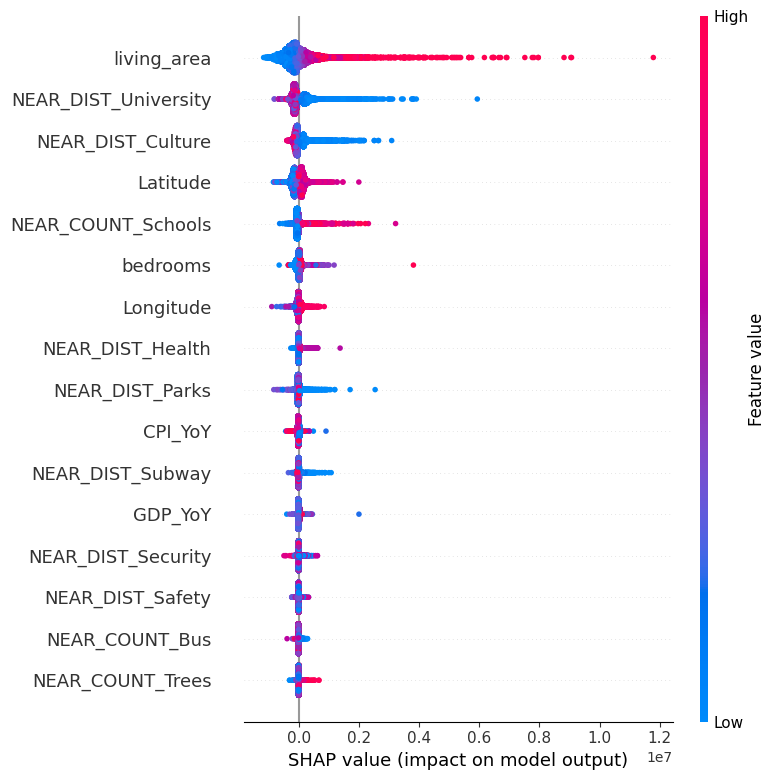

In [32]:
import shap
import matplotlib.pyplot as plt

# Create a SHAP explainer
explainer1 = shap.TreeExplainer(model1)

interaction_values1 = explainer1.shap_interaction_values(X1)

# Calculate SHAP values
shap_values1 = explainer1.shap_values(X1)

# Create SHAP summary plot
shap.summary_plot(shap_values1, X1)  # You can use "bar" for bar plot


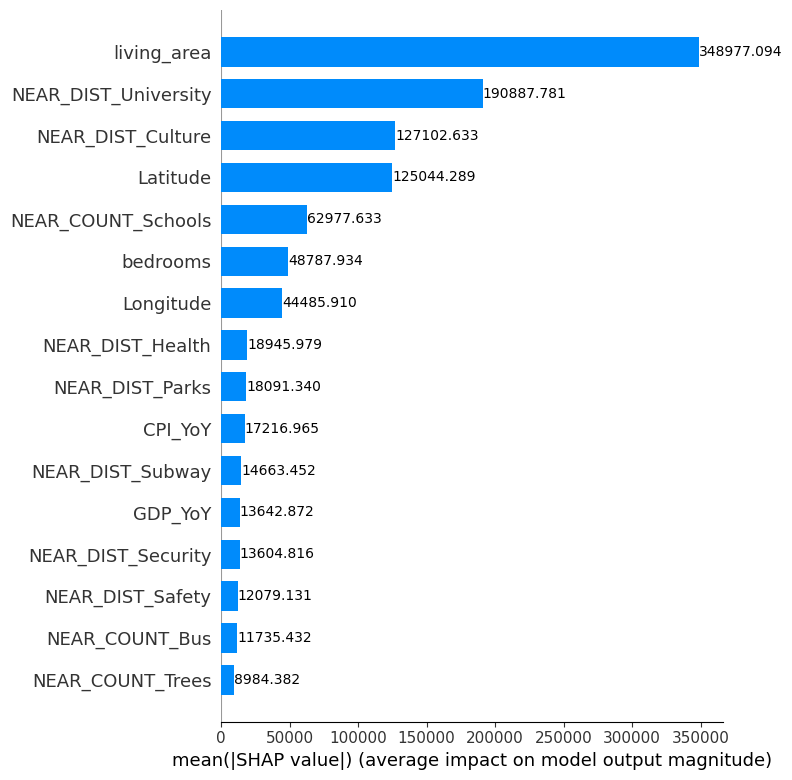

In [33]:
# plot a bar chart of the feature importances

# Create summary plot with numbers
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values1, X1, plot_type="bar", show=False)

# Get the current axis
ax = plt.gca()

# Add text annotations for each bar
for i, bar in enumerate(ax.patches):
    width = bar.get_width()
    # Add text annotation at the end of each bar
    plt.text(width, bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}',
             ha='left', va='center')

plt.tight_layout()
plt.show()

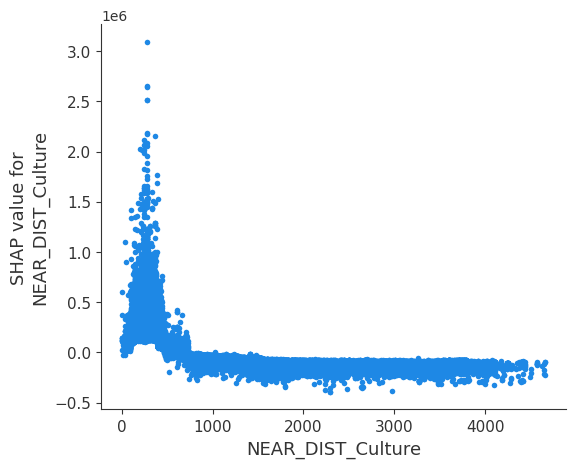

In [61]:
shap.dependence_plot(
    "NEAR_DIST_Culture",   # the feature you're analyzing
    shap_values1,          # SHAP values (from TreeExplainer)
    X1,                     # the original input DataFrame
    interaction_index=None  # disables coloring by interacting feature
)

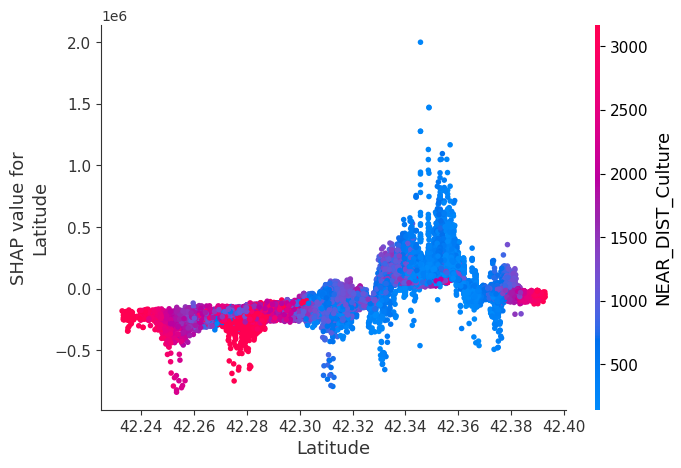

In [62]:
# Dependence plot of culture district distance
shap.dependence_plot(
    "Latitude",    # feature whose SHAP values to plot on y-axis
    shap_values1,             # SHAP values array (not the whole object)
    X1,                              # the input features
    interaction_index="NEAR_DIST_Culture"     # color points by this interacting variable
)

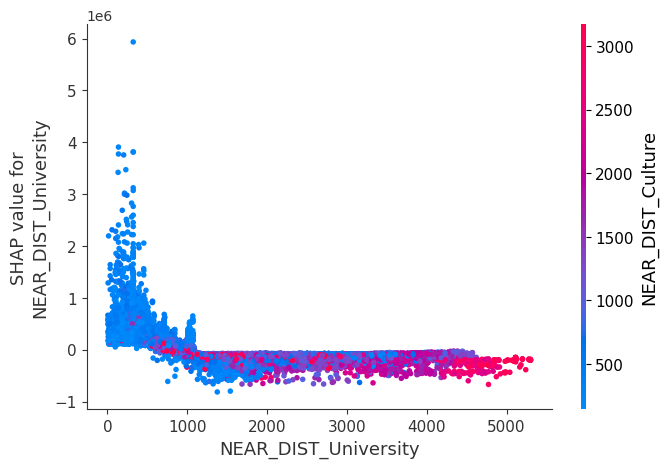

In [63]:
shap.dependence_plot(
    "NEAR_DIST_University",    # feature whose SHAP values to plot on y-axis
    shap_values1,             # SHAP values array (not the whole object)
    X1,                              # the input features
    interaction_index="NEAR_DIST_Culture"     # color points by this interacting variable
)

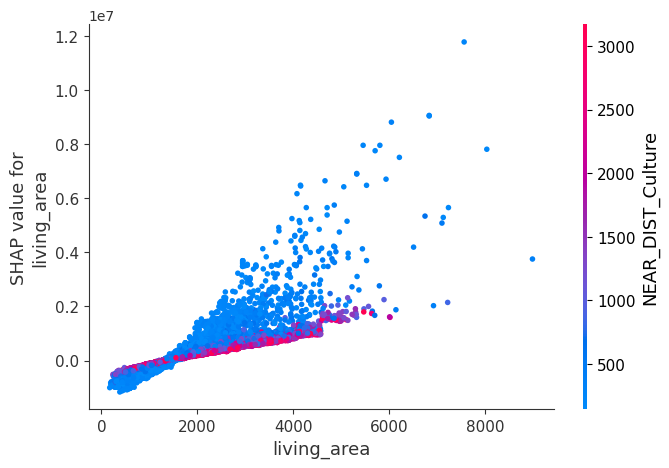

In [64]:
shap.dependence_plot(
    "living_area",    # feature whose SHAP values to plot on y-axis
    shap_values1,             # SHAP values array (not the whole object)
    X1,                              # the input features
    interaction_index="NEAR_DIST_Culture"     # color points by this interacting variable
)

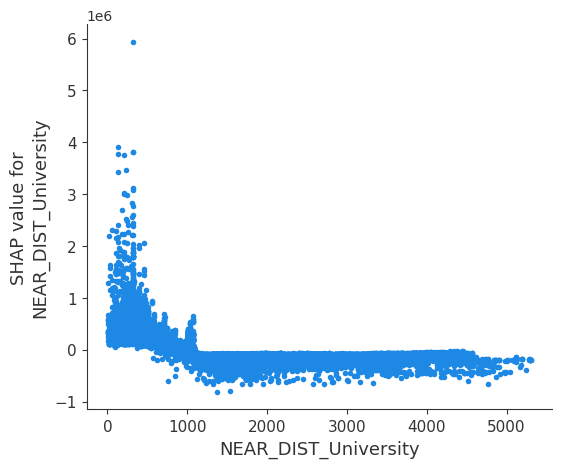

In [65]:
shap.dependence_plot(
    "NEAR_DIST_University",   # the feature you're analyzing
    shap_values1,          # SHAP values (from TreeExplainer)
    X1,                     # the original input DataFrame
    interaction_index=None  # disables coloring by interacting feature
)

In [46]:
shap_df = pd.DataFrame(shap_values1, columns=X1.columns)
# save df
shap_df.to_csv('data/shap_values.csv', index=False)


In [47]:
len(data)

30708

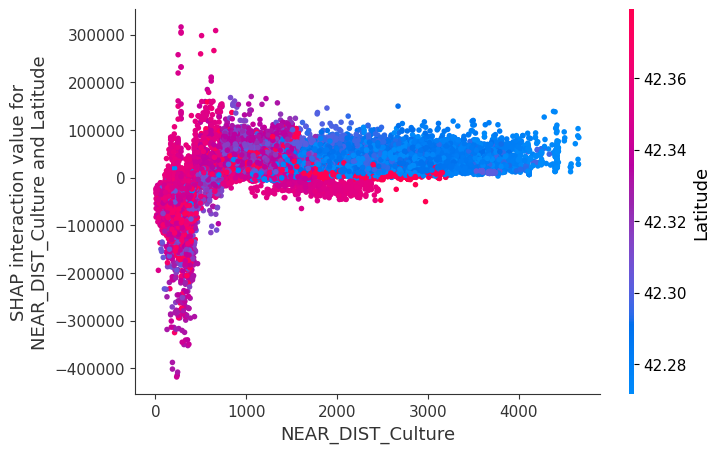

In [48]:
shap.dependence_plot(
    ("NEAR_DIST_Culture", "Latitude"),
    interaction_values1,
    X1
)

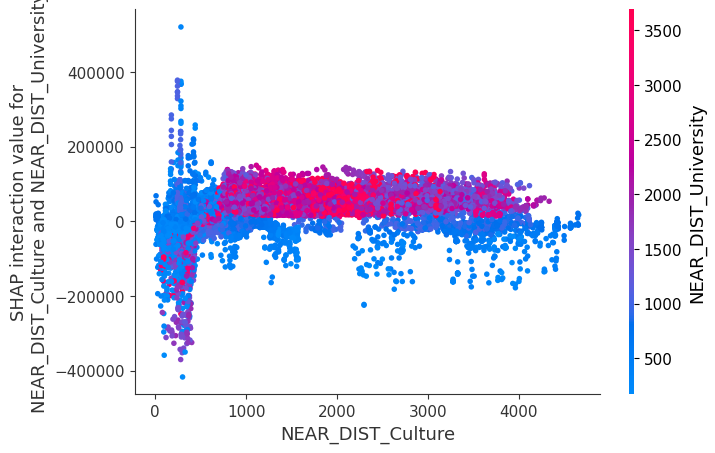

In [49]:
shap.dependence_plot(
    ("NEAR_DIST_Culture", "NEAR_DIST_University"),
    interaction_values1,
    X1
)

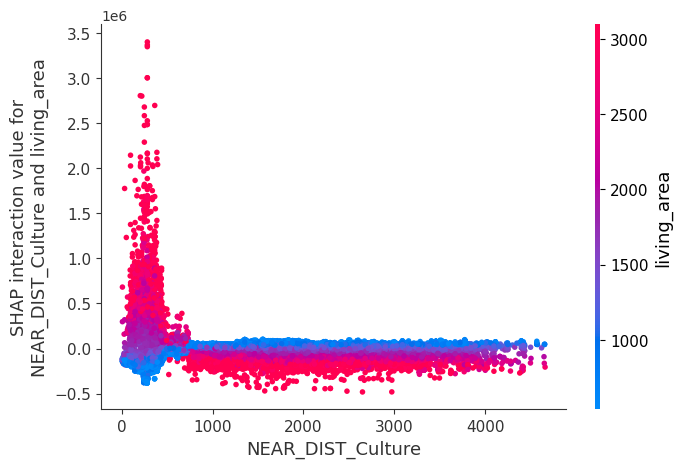

In [50]:
shap.dependence_plot(
    ("NEAR_DIST_Culture", "living_area"),
    interaction_values1,
    X1
)

In [51]:
# now we do with the mixed culture district
X2 = data[X2_cols]

# Initialize model with same parameters
# model = XGBRegressor()

model2 = XGBRegressor(
        n_estimators=500,
        learning_rate=0.03,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
    )


# Perform 5-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model2, X2, Y, cv=kf, scoring='r2')

# Print cross validation results
print("Cross Validation Scores:")
for i, score in enumerate(cv_scores, 1):
    print(f"Fold {i}: {score:.4f}")
print(f"\nMean CV Score: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")

# Fit the model on the full dataset to get feature importances
model2.fit(X2, Y)

# Print feature importances
print("\nFeature importances:")
print(model2.feature_importances_)

Cross Validation Scores:
Fold 1: 0.8787
Fold 2: 0.9305
Fold 3: 0.9173
Fold 4: 0.9131
Fold 5: 0.8739

Mean CV Score: 0.9027
Standard Deviation: 0.0224

Feature importances:
[0.04149305 0.00560789 0.00567956 0.1457584  0.02297984 0.09641426
 0.04139298 0.03197281 0.0146167  0.1516018  0.03246252 0.01875508
 0.09290352 0.0172552  0.01374904 0.26735732]


In [52]:
# Get feature importances from XGBoost model
importances = model2.feature_importances_

# Create dictionary mapping features to their importance scores
importance_dict = dict(zip(X2.columns, importances))

# Print feature importances in order
print("Feature Importances:")
for feature, importance in sorted(importance_dict.items(), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {importance:.4f}")


Feature Importances:
NEAR_DIST_Culture_District: 0.2674
NEAR_DIST_University: 0.1516
living_area: 0.1458
Latitude: 0.0964
NEAR_COUNT_Schools: 0.0929
bedrooms: 0.0415
NEAR_DIST_Parks: 0.0414
NEAR_DIST_Security: 0.0325
NEAR_DIST_Health: 0.0320
Longitude: 0.0230
NEAR_DIST_Subway: 0.0188
NEAR_COUNT_Bus: 0.0173
NEAR_DIST_Safety: 0.0146
NEAR_COUNT_Trees: 0.0137
CPI_YoY: 0.0057
GDP_YoY: 0.0056


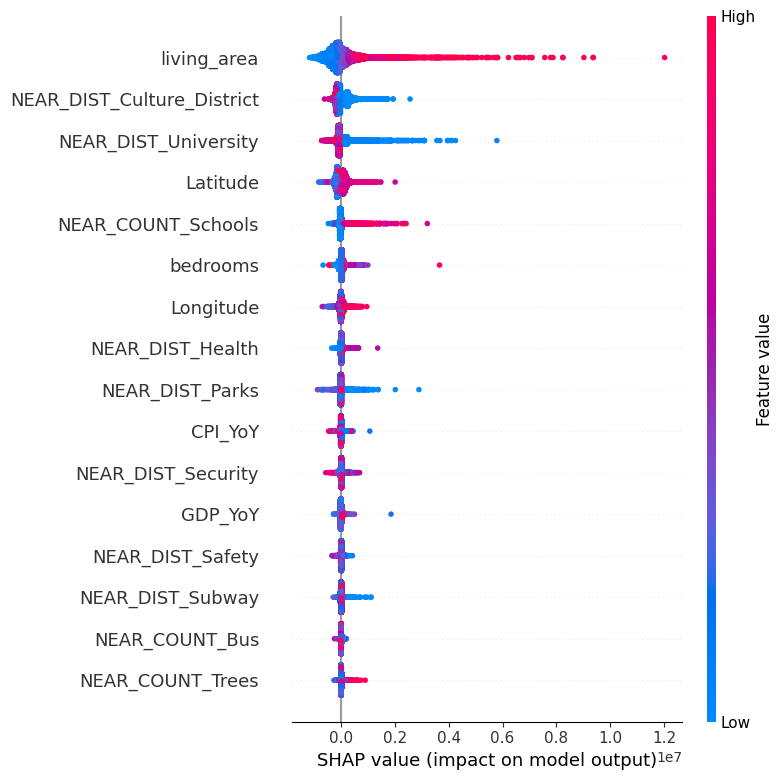

In [53]:
import shap
import matplotlib.pyplot as plt

# Create a SHAP explainer
explainer2 = shap.TreeExplainer(model2)

# Calculate SHAP values
shap_values2 = explainer2.shap_values(X2)

interaction_values2 = explainer2.shap_interaction_values(X2)

# Create SHAP summary plot
shap.summary_plot(shap_values2, X2)  # You can use "bar" for bar plot


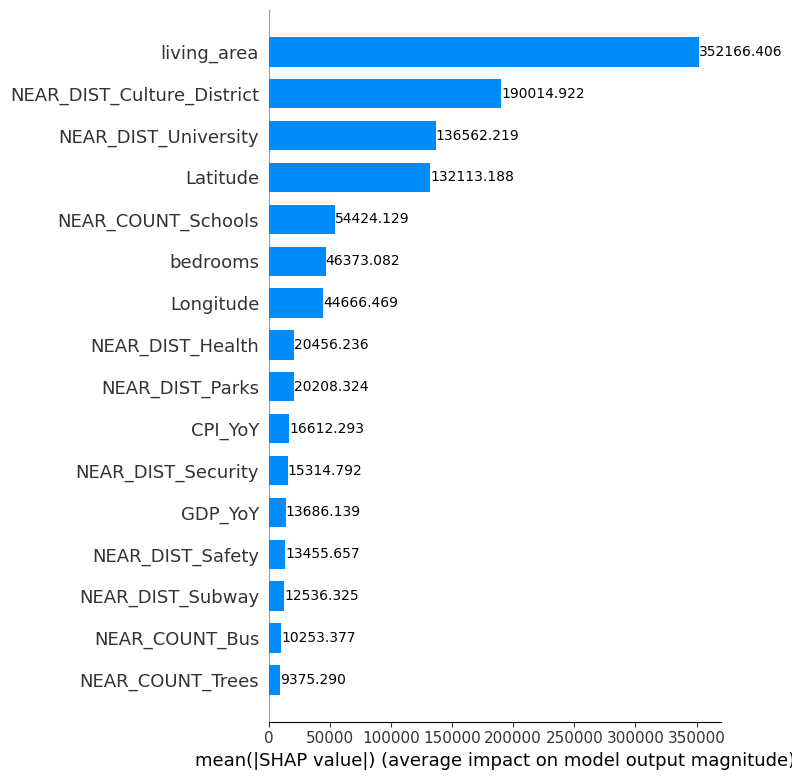

In [54]:
# plot a bar chart of the feature importances

# shap.summary_plot(shap_values2, X2, plot_type="bar")

# plot a bar chart of the feature importances

# Create summary plot with numbers
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values2, X2, plot_type="bar", show=False)

# Get the current axis
ax = plt.gca()

# Add text annotations for each bar
for i, bar in enumerate(ax.patches):
    width = bar.get_width()
    # Add text annotation at the end of each bar
    plt.text(width, bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}',
             ha='left', va='center')

plt.tight_layout()
plt.show()

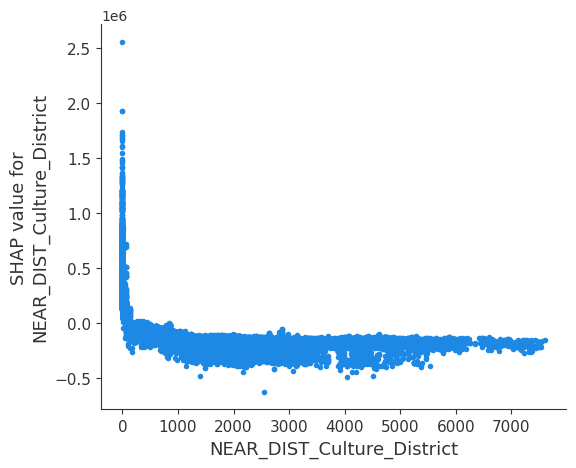

In [69]:
shap.dependence_plot(
    "NEAR_DIST_Culture_District",   # the feature you're analyzing
    shap_values2,          # SHAP values (from TreeExplainer)
    X2,                     # the original input DataFrame
    interaction_index=None  # disables coloring by interacting feature
)

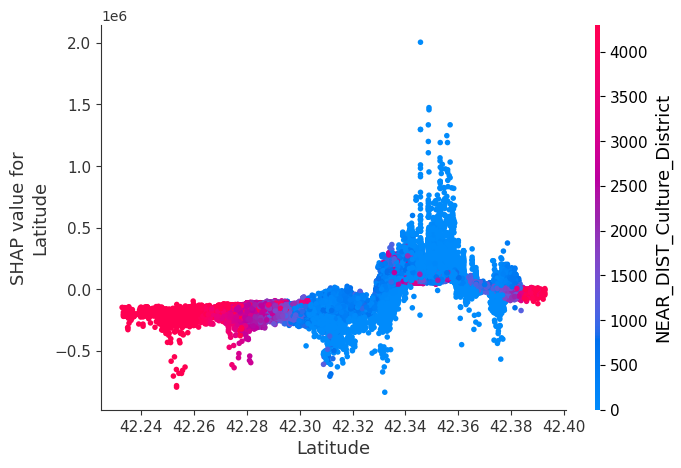

In [66]:
# Dependence plot of culture district distance
shap.dependence_plot(
    "Latitude",    # feature whose SHAP values to plot on y-axis
    shap_values2,             # SHAP values array (not the whole object)
    X2,                              # the input features
    interaction_index="NEAR_DIST_Culture_District"     # color points by this interacting variable
)

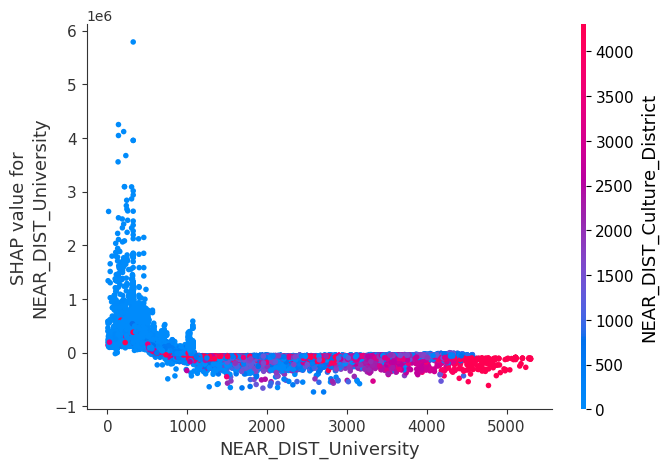

In [67]:
# Dependence plot of culture district distance
shap.dependence_plot(
    "NEAR_DIST_University",    # feature whose SHAP values to plot on y-axis
    shap_values2,             # SHAP values array (not the whole object)
    X2,                              # the input features
    interaction_index="NEAR_DIST_Culture_District"     # color points by this interacting variable
)

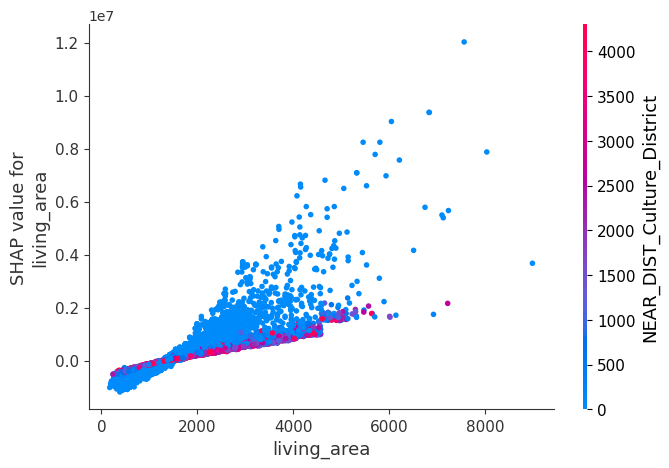

In [68]:
# Dependence plot of culture district distance
shap.dependence_plot(
    "living_area",    # feature whose SHAP values to plot on y-axis
    shap_values2,             # SHAP values array (not the whole object)
    X2,                              # the input features
    interaction_index="NEAR_DIST_Culture_District"     # color points by this interacting variable
)

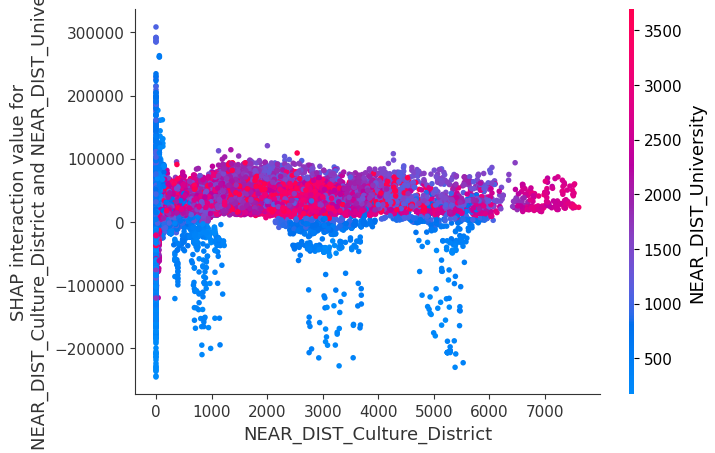

In [57]:
shap.dependence_plot(
    ("NEAR_DIST_Culture_District", "NEAR_DIST_University"),
    interaction_values2,
    X2
)

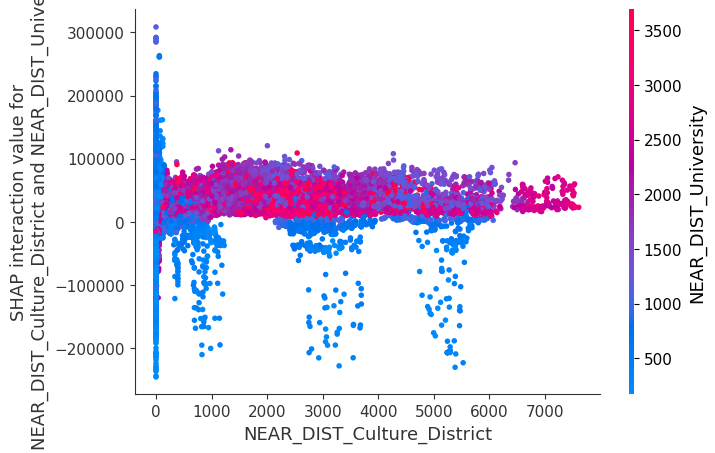

In [58]:
shap.dependence_plot(
    ("NEAR_DIST_Culture_District", "NEAR_DIST_University"),
    interaction_values2,
    X2
)

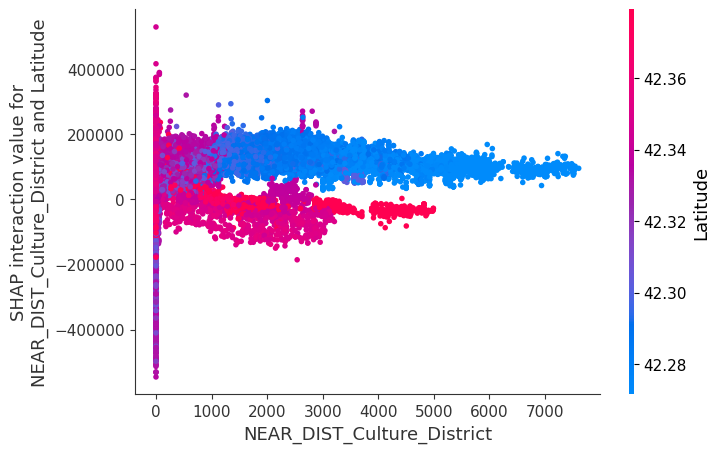

In [59]:
shap.dependence_plot(
    ("NEAR_DIST_Culture_District", "Latitude"),
    interaction_values2,
    X2
)

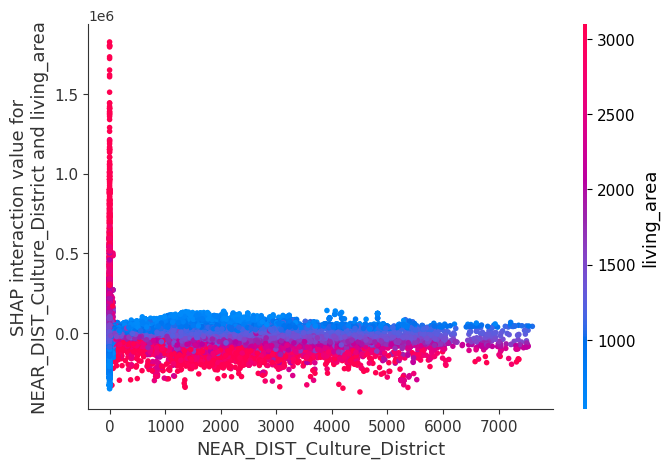

In [60]:
shap.dependence_plot(
    ("NEAR_DIST_Culture_District", "living_area"),
    interaction_values2,
    X2
)

<Axes: >

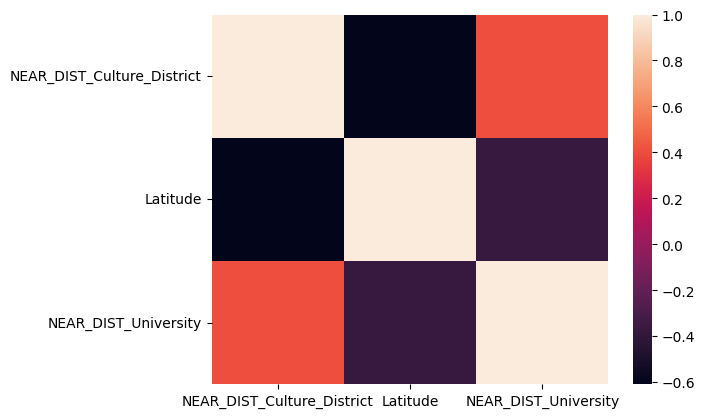

In [89]:
import seaborn as sns

sns.heatmap(X2[["NEAR_DIST_Culture_District", "Latitude", "NEAR_DIST_University"]].corr())

In [75]:
X_common

['bedrooms',
 'GDP_YoY',
 'CPI_YoY',
 'living_area',
 'Longitude',
 'Latitude',
 'NEAR_DIST_Parks',
 'NEAR_DIST_Health',
 'NEAR_DIST_Safety',
 'NEAR_DIST_University',
 'NEAR_DIST_Security',
 'NEAR_DIST_Subway',
 'NEAR_COUNT_Schools',
 'NEAR_COUNT_Bus',
 'NEAR_COUNT_Trees']

In [45]:
all_x = X_common + ["NEAR_DIST_Culture", "NEAR_DIST_Culture_District"]

# now we do with all the data
X = data[all_x]

# Initialize model with same parameters
model = XGBRegressor()


# Perform 5-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X, Y, cv=kf, scoring='r2')

# Print cross validation results
print("Cross Validation Scores:")
for i, score in enumerate(cv_scores, 1):
    print(f"Fold {i}: {score:.4f}")
print(f"\nMean CV Score: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")

# Fit the model on the full dataset to get feature importances
model.fit(X, Y)

# Print feature importances
print("\nFeature importances:")
print(model.feature_importances_)

Cross Validation Scores:
Fold 1: 0.4637
Fold 2: 0.3671
Fold 3: 0.3309
Fold 4: 0.4191
Fold 5: 0.2842

Mean CV Score: 0.3730
Standard Deviation: 0.0633

Feature importances:
[0.05825448 0.05414545 0.02803902 0.04759371 0.0369596  0.02952042
 0.02624639 0.0394957  0.04015504 0.02289393 0.02368708 0.43998384
 0.05270435 0.05377636 0.04654453]


In [46]:
# Get feature importances from XGBoost model
importances = model.feature_importances_

# Create dictionary mapping features to their importance scores
importance_dict = dict(zip(X.columns, importances))

# Print feature importances in order
print("Feature Importances:")
for feature, importance in sorted(importance_dict.items(), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {importance:.4f}")


Feature Importances:
Latitude: 0.4400
GROSS_AREA: 0.0583
BED_RMS: 0.0541
NEAR_DIST_Culture: 0.0538
Longitude: 0.0527
NEAR_DIST_Health: 0.0476
NEAR_DIST_Mixed_Culture_District: 0.0465
NEAR_DIST_University: 0.0402
NEAR_DIST_Subway: 0.0395
NEAR_DIST_Park: 0.0370
NEAR_DIST_Safety: 0.0295
BUS_CNT: 0.0280
NEAR_DIST_Security: 0.0262
TREE_CNT: 0.0237
SCHOOL_CNT: 0.0229


100%|===================| 119727/120158 [02:50<00:00]        

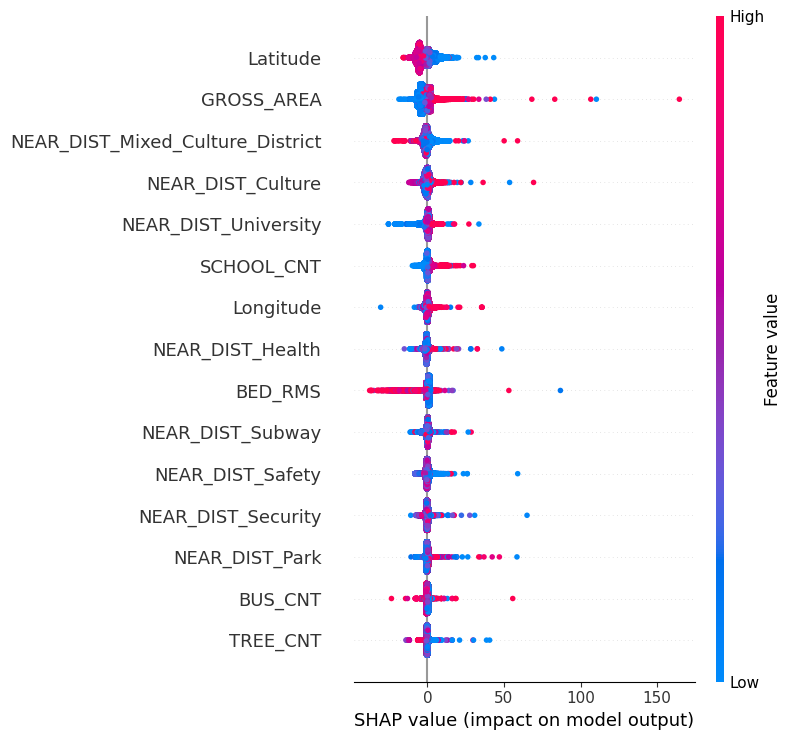

In [47]:
import shap
import matplotlib.pyplot as plt

# Create a SHAP explainer
explainer = shap.Explainer(model, X)

# Calculate SHAP values
shap_values = explainer(X)

# Create SHAP summary plot
shap.summary_plot(shap_values, X)  # You can use "bar" for bar plot


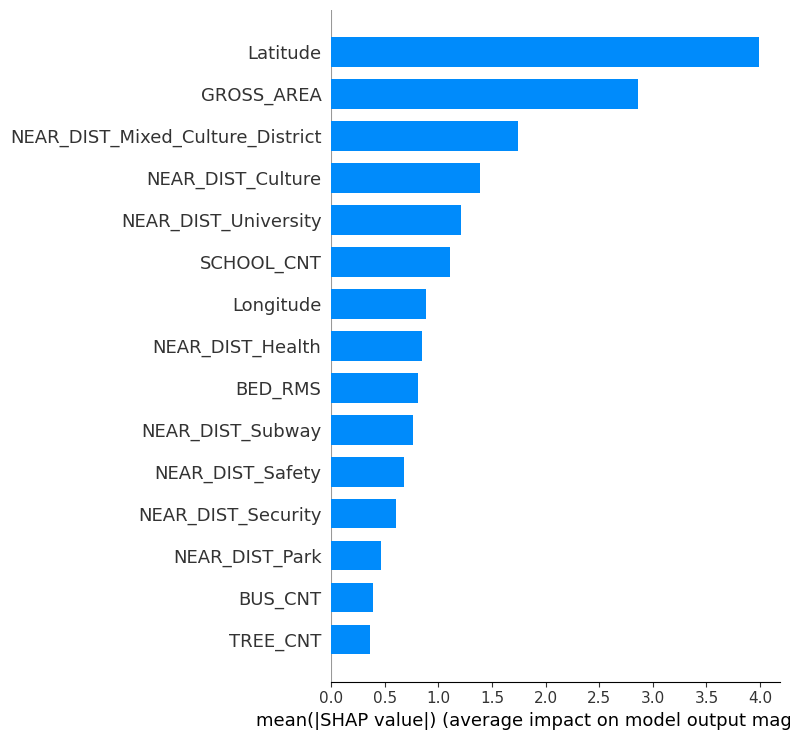

In [48]:
# plot a bar chart of the feature importances

shap.summary_plot(shap_values, X, plot_type="bar")